In [51]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tqdm import trange

In [52]:
housing = fetch_california_housing()
X = housing.data
y = housing.target
housing.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [54]:
X.shape

(20640, 8)

In [55]:
y = np.expand_dims(y,axis=-1)

In [56]:
X -= X.min(axis=0)
X /= X.max(axis=0)

In [57]:
len(X)

20640

In [58]:
X = torch.tensor(X).float().cuda()
y = torch.tensor(y).float().cuda()

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=42)

In [60]:
loss_fn = nn.MSELoss()

In [61]:
def train_loop(model,lr=1e-2,epochs=2000,weight_decay=1e-4):
  opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

  train_mses = []
  test_mses = []

  best_test_mse = np.inf

  for epoch in trange(epochs):
    model.train()
    opt.zero_grad()

    pred = model(X_train)
    loss = loss_fn(pred,y_train)

    loss.backward()

    opt.step()

    train_mses.append(loss.item())

    model.eval()
    pred = model(X_test)
    test_mse = loss_fn(pred,y_test).item()

    if test_mse < best_test_mse:
      best_test_mse = test_mse
      torch.save(model.state_dict(), 'best.ckpt')

    test_mses.append(test_mse)

  model.load_state_dict(torch.load('best.ckpt', weights_only=True))

  model.eval()
  pred = model(X_train)
  best_train_mse = loss_fn(pred,y_train).item()

  pred = model(X_test)
  best_test_mse = loss_fn(pred,y_test).item()

  return train_mses, test_mses, best_train_mse, best_test_mse

In [62]:
def make_plot(train_mses,test_mses):
  plt.plot(train_mses)
  plt.plot(test_mses)
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend(['Train','Test'])

In [63]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [64]:
def evaluate_model(model,*args,**kwargs):
  train_mses, test_mses, best_train_mse, best_test_mse = train_loop(model,*args,**kwargs)

  make_plot(train_mses,test_mses)

  print(f'# parameters: {count_parameters(model)}')
  print(f'best train loss:{best_train_mse}')
  print(f'best test loss:{best_test_mse}')

In [65]:
hidden_size = 100
num_hidden = 3
hidden_layers = []
for i in range(num_hidden):
    hidden_layers.append(nn.Linear(hidden_size,hidden_size))
    hidden_layers.append(nn.SiLU())
nn_model = nn.Sequential(
    nn.Linear(8,hidden_size),
    *hidden_layers,
    nn.Linear(hidden_size,1)
).cuda()

100%|██████████| 2000/2000 [00:20<00:00, 95.60it/s]


# parameters: 31301
best train loss:0.3102852404117584
best test loss:0.3460031747817993


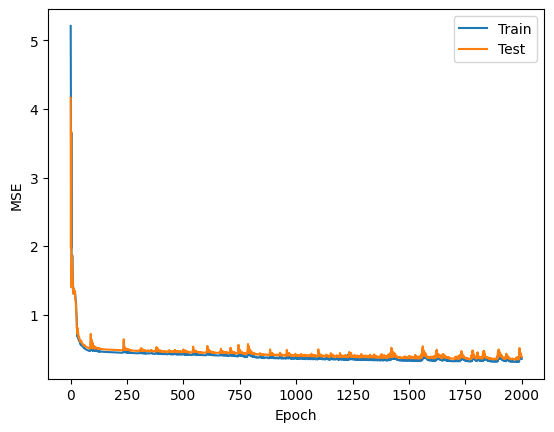

In [66]:
evaluate_model(nn_model)

In [67]:
hidden_size = 100
num_hidden = 15
hidden_layers = []
for i in range(num_hidden):
    hidden_layers.append(nn.Linear(hidden_size,hidden_size))
    hidden_layers.append(nn.SiLU())
nn_model = nn.Sequential(
    nn.Linear(8,hidden_size),
    *hidden_layers,
    nn.Linear(hidden_size,1)
).cuda()

In [68]:
pred = nn_model(X_train)
loss = loss_fn(pred,y_train)
loss.backward()

Text(0, 0.5, 'Gradient magnitude')

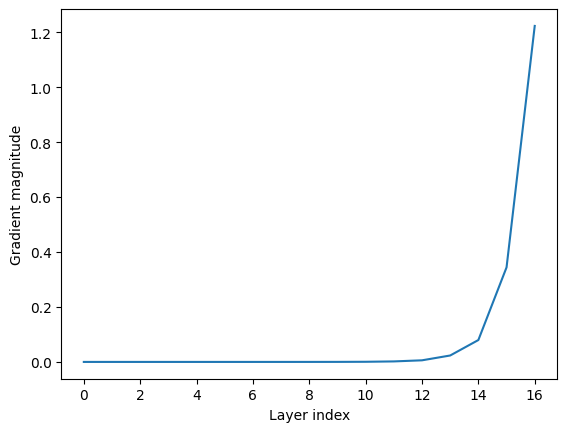

In [69]:
grads = []
for name,m in nn_model.named_modules():
    if type(m) is nn.Linear:
        for p in m.parameters():
            g = torch.sqrt(torch.sum(p.grad**2)).item()
            grads.append(g)
            break
plt.plot(range(len(grads)),grads)
plt.xlabel('Layer index')
plt.ylabel('Gradient magnitude')

100%|██████████| 2000/2000 [00:51<00:00, 38.97it/s]


# parameters: 152501
best train loss:0.41970890760421753
best test loss:0.4577867090702057


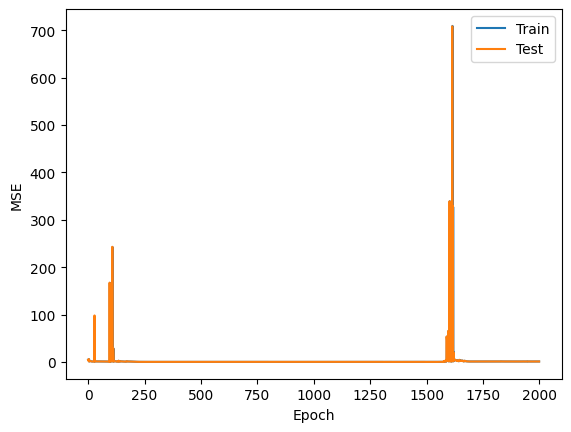

In [70]:
evaluate_model(nn_model)

In [71]:
class LinearWithResidual(nn.Module):
    def __init__(self,in_features,out_features):
        super().__init__()
        self.linear = nn.Linear(in_features,out_features)
        self.act = nn.SiLU()

    def forward(self,x):
        z = self.act(self.linear(x))+x
        return z
    

In [72]:
hidden_size = 100
num_hidden = 15
hidden_layers = []
for i in range(num_hidden):
    hidden_layers.append(LinearWithResidual(hidden_size,hidden_size))
nn_model = nn.Sequential(
    nn.Linear(8,hidden_size),
    *hidden_layers,
    nn.Linear(hidden_size,1)
).cuda()

In [73]:
pred = nn_model(X_train)
loss = loss_fn(pred,y_train)
loss.backward()

Text(0, 0.5, 'Gradient magnitude')

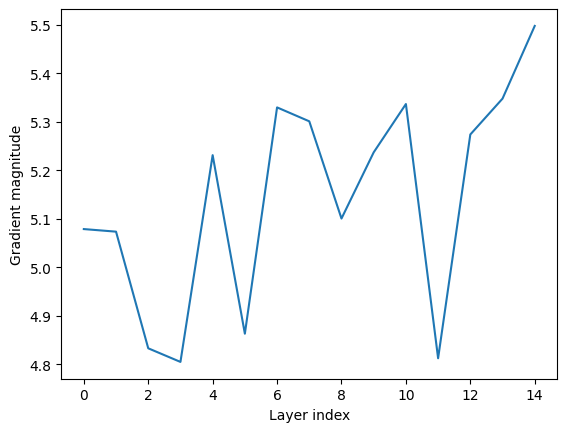

In [74]:
grads = []
for name,m in nn_model.named_modules():
    if type(m) is LinearWithResidual:
        p = list(m.parameters())[0]
        g = torch.sqrt(torch.sum(p.grad**2)).item()
        grads.append(g)
plt.plot(range(len(grads)),grads)
plt.xlabel('Layer index')
plt.ylabel('Gradient magnitude')
# plt.ylim([0,0.055])

100%|██████████| 2000/2000 [01:01<00:00, 32.45it/s]


# parameters: 152501
best train loss:0.3288308382034302
best test loss:0.375780314207077


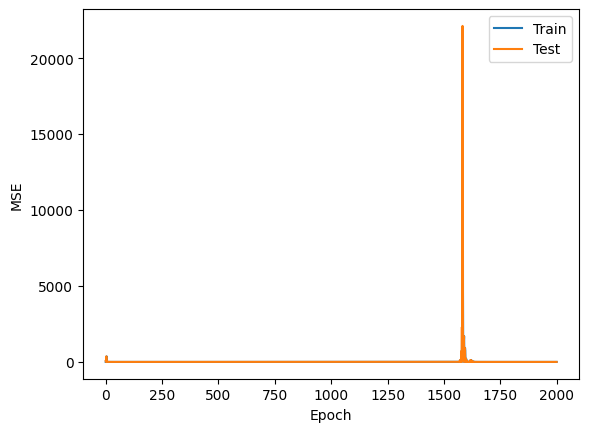

In [75]:
evaluate_model(nn_model)